In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 13 11:40:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P8    18W / 100W |     54MiB /  6144MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv
import random

2024-06-13 11:40:07.488393: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 11:40:07.489787: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 11:40:07.514509: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 11:40:07.515416: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 11:40:08.187659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1 
BATCH_SIZE=90

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=50000
LEARNING_RATE=0.001

# Gym CartPole-v1

Un péndulo está unido mediante una articulación no accionada a un carro que se desplaza a lo largo de una pista sin fricción. El péndulo se coloca verticalmente sobre el carro y el objetivo es equilibrar el poste aplicando fuerzas en dirección izquierda y derecha sobre el carro.

**Espacio de Acciones**: Espacio discreto de tamaño (2)

* Acción 0: Empujar el carro hacia la izquierda
* Acción 1: Empujar el carro hacia la derecha

**Espacio de Observaciones**: Espacio continuuo de tamaño (4,)

* La observación es un ndarray con forma (4,) con los valores correspondientes a las siguientes posiciones y velocidades:
    * Num     |     Observación |     Min |    Max

    * 0    Posición del Carro                 - 4.8                            4.8

    *  1    Velocidad del Carro                 -Inf                            Inf

    * 2    Ángulo del Poste              ~ -0.418 rad (-24°)          ~ 0.418 rad (24°)

    * 3    Velocidad Angular del Poste         -Inf                            Inf





In [6]:
# Definimos el entorno
env= gym.make('CartPole-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

2
4


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o sintéticas, de longitud ob_space.shape[0] + ac_space.n.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n)),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 10)          70        
                                                                 
 layer2 (Dense)              (None, None, 10)          110       
                                                                 
 layer3 (Dense)              (None, None, 10)          110       
                                                                 
 prob (Dense)                (None, None, 1)           11        
                                                                 
Total params: 301 (1.18 KB)
Trainable params: 301 (1.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-06-13 11:40:10.478389: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-13 11:40:10.478416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-13 11:40:10.478420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-13 11:40:10.478511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-06-13 11:40:10.478521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-06-13 11:40:10.478524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [9]:
#########################################################################################
# Clase DISCRIMINADOR
########################################################################################
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 4, s=[s1,s2,s3,s4]
# Output: acciones, listas de tamaño 2, a=[a1,a2]
generator_net_Act=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation=tf.tanh,name='layer1'),
            layers.Dense(units=6, activation=tf.tanh, name='layer2'),
            layers.Dense(units=4, activation=tf.tanh, name='layer3'),
            layers.Dense(units=2, activation=tf.nn.softmax, name='layer4')

        ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           30        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 4)           28        
                                                                 
 layer4 (Dense)              (None, None, 2)           10        
                                                                 
Total params: 110 (440.00 Byte)
Trainable params: 110 (440.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 4, s=[s0,s1,s2,s3]
# Output: v_pred, listas de tamaño 1, v_pred
generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation=tf.tanh,name='layer1'),
            layers.Dense(units=6, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           30        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 1)           7         
                                                                 
Total params: 79 (316.00 Byte)
Trainable params: 79 (316.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################
def loss_fn_ppo(v_preds,act_probs,act_probs_old,gaes,clip_value=0.2,entcoeff=0.01):
    """ 
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)

    # L^{clip}_t (θ)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    pol_surr = -loss_clip  # ---YA LA  TENIAMOS

    #--------------- NUEVO---------
    
    # c_1* L^{VF}_t (θ)  is a squared-error loss
    # Empirical return
    vf_loss = tf.reduce_mean(tf.square(v_preds))


    # c_2 * S[πθ](st) where S  denotes an entropy bonus
    # --Calcular la distribución de probabilidad normalizada
    normalized_distribution = act_probs / tf.reduce_sum(act_probs)
    
    # --Calcular la entropía
    ent = -tf.reduce_sum(normalized_distribution * tf.math.log(normalized_distribution))

    meanent = tf.reduce_mean(ent)
    pol_entpen = (-entcoeff) * meanent

    total_loss = pol_surr + pol_entpen + vf_loss
    tf.summary.scalar('total', total_loss)

    return total_loss""" 

    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
  def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



  # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
  # La elección de la acción puede ser estocástica o determinística
  def act(self, stochastic=True):
      if stochastic:
          return self.act_stochastic, self.v_preds
      else:
          return self.act_deterministic, self.v_preds

  def get_action_prob(self):
      return self.act_probs

  def get_v_preds(self):
      return self.v_preds

  def get_obs(self):
      return self.obs

  def get_model(self):
      return self.model

  def get_trainable_variables(self):
      return self.model.get_parameters()

  # Generar [s,a] falsos
  def generate_fakes(self):

      ob_space = env.observation_space
      reward = 0
      success_num = 0

      # Por cada episodio
      for iteration in range(EPISODES):
          # Inicializo todas las variables
          observations = []
          actions = []
          rewards = []
          run_policy_steps = 0

          truncated=False
          terminated=False


          #La primera acción de cada episodio se crea con la red neuronal

          obs,_=env.reset()

          Old_Policy = Policy_net('old_policy', env, obs=obs)

          act, v_pred = Old_Policy.act(stochastic=True)

          #Convertir de tensor a array
          if type(act)=='Tensor':
              # Crear una sesión de TensorFlow
              sess = tf.compat.v1.Session()

              # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
              act = sess.run(act)

              # Cerrar la sesión
              sess.close()

          if isinstance(act, tf.Tensor):
              act=act.numpy()

          elif isinstance(act, np.ndarray):
              act=act


          action=int(act)

          next_obs,reward,terminated,truncated, info=env.step(action)

          # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
          observations.append(next_obs)  # S_0

          Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

          # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
          while terminated!= True and truncated!= True:
              # --Aumentar el numero de steps
              run_policy_steps += 1

              # --Política para ver la acción asociada al estado
              # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
              action, states_oc = Policy.get_model().predict(next_obs)

              action=int(action)

              # --Muevo al Agente al siguiente estado
              next_obs,reward,terminated,truncated,info=env.step(action)

              # --Actualización de variables
              actions.append(action) # A_i-1
              rewards.append(reward) # R_i-1

              # --Si llegamos a un estado final, el juego ha finalizado!!!
              # --Se configura el tablero de nuevo
              if terminated== True or truncated==True:
                  obs = env.reset()
                  reward = -1
                  break
              else:
                  observations.append(next_obs) # O_i
                  self.obs = next_obs

          # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
          if sum(rewards) >= 195:
              success_num += 1
              if success_num >= 100:
                  break
          else:
              success_num = 0
             

      observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
      actions = np.array(actions).astype(dtype=np.int32)


      return observations, actions, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:
  def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.v_preds_next, self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

  def loss_fn_G(self):
      return loss_fn_ppo(self.v_preds_next,self.act_probs, self.act_probs_old, self.gaes)

  def get_pi_trainable(self):
      return self.pi

  def get_optimizer(self):
      return self.optimizer

  def get_OldPolicy(self):
      return self.Old_Policy

  def get_Policy(self):
      return self.Policy

  def get_gaes(self, rewards, v_preds, v_preds_next):
      deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
      # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
      gaes = copy.deepcopy(deltas)
      for t in reversed(range(len(gaes) - 1)):  # # es T-1, donde T es time step con el que se ejecuta la política
          gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
      return gaes

# GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('CartPole-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):
        
        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        
        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, (generate_observations.shape[0],2))
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento  
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices]
        
        
        ## 3) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento y las combinamos
        combined_images = tf.concat([X_train, dataset_gen], axis=0)
    

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )

        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

        
        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}




# Experimentación de GAIL con CartPole

## Experimento 1


### Construcción de base de datos experta con 1 trayectoria 

In [16]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [17]:
print(expert_num_tray)

[0 0 0 ... 9 9 9]


In [18]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

500


In [19]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:308]
expert_actions=expert_actions[0:308]

In [20]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.0427408   0.15409148  0.01132174 -0.22373803]
 [-0.03965897 -0.04119044  0.00684698  0.0724946 ]
 [-0.04048278  0.15383267  0.00829687 -0.21802023]]
	Acciones reales: 
 [1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0
 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0
 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1
 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 0 1 0]


### Separación de Train y Test

In [21]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.00572823 -0.03831238  0.03101629  0.00900886  0.          1.        ]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897  1.          0.        ]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788  0.          1.        ]
 ...
 [-0.0427408   0.15409148  0.01132174 -0.22373803  1.          0.        ]
 [-0.03965897 -0.04119044  0.00684698  0.0724946   0.          1.        ]
 [-0.04048278  0.15383267  0.00829687 -0.21802023  1.          0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 246
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 62


In [22]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

/home/usuario/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [23]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [24]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [25]:
import csv

In [26]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan1.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)

/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(





d_loss= 2.6998672

g_loss= -1.2937802
1/3 [=========>....................] - ETA: 16:16 - d_loss: 2.6999 - g_loss: -1.2938


d_loss= 2.6640248

g_loss= -0.85499656
2/3 [===================>..........] - ETA: 7:44 - d_loss: 2.6819 - g_loss: -1.0744 


d_loss= 2.6732821

g_loss= -0.783127
3/3 [==============================] - 1397s 454s/step - d_loss: 2.6791 - g_loss: -0.9773


### Evaluación de GAIL

In [27]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.7776 - accuracy: 1.0000
>Loss real: 
0.7573800683021545
>Loss fake: 
0.7775967717170715


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

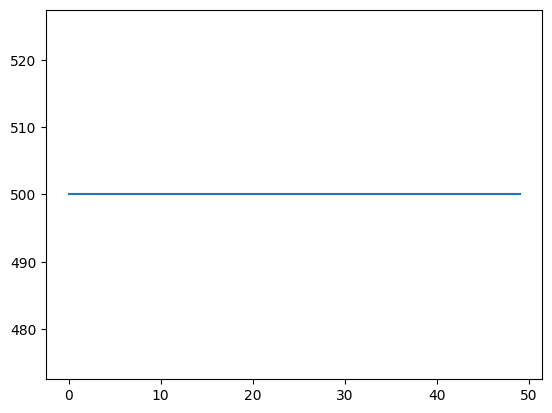


Recompensa de Media: 500.0 



In [28]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2


### Construcción de base de datos experta con 2 trayectoria 

In [29]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [30]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1000


In [31]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:1000]
expert_actions=expert_actions[0:1000]



In [32]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.02125562 -0.14190234  0.00628069  0.19885743]
 [-0.02409366  0.05312921  0.01025783 -0.09183763]
 [-0.02303108  0.24810264  0.00842108 -0.38126662]]
	Acciones reales: 
 [1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0
 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0
 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1
 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1
 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0

In [33]:
print(converted_observations.shape)

(1000, 4)


### Separación de Train y Test

In [34]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.00572823 -0.03831238  0.03101629  0.00900886  0.          1.        ]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897  1.          0.        ]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788  0.          1.        ]
 ...
 [-0.02125562 -0.14190234  0.00628069  0.19885743  0.          1.        ]
 [-0.02409366  0.05312921  0.01025783 -0.09183763  0.          1.        ]
 [-0.02303108  0.24810264  0.00842108 -0.38126662  1.          0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 800
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 200


In [35]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [36]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [37]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [38]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan2.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.6745842

g_loss= -0.72911835
1/9 [==>...........................] - ETA: 58:58 - d_loss: 2.6746 - g_loss: -0.7291


d_loss= 2.6363215

g_loss= -0.9000978
2/9 [=====>........................] - ETA: 55:46 - d_loss: 2.6555 - g_loss: -0.8146


d_loss= 2.6540318

g_loss= -1.2918525
3/9 [=========>....................] - ETA: 46:52 - d_loss: 2.6550 - g_loss: -0.9737


d_loss= 2.641611

g_loss= -1.1025237
4/9 [============>.................] - ETA: 38:36 - d_loss: 2.6516 - g_loss: -1.0059


d_loss= 2.5994596

g_loss= -0.8518355
5/9 [===============>..............] - ETA: 31:03 - d_loss: 2.6412 - g_loss: -0.9751


d_loss= 2.6370044

g_loss= -0.8713863
6/9 [===================>..........] - ETA: 23:15 - d_loss: 2.6405 - g_loss: -0.9578


d_loss= 2.6268873

g_loss= -0.94496644
7/9 [======================>.......] - ETA: 15:35 - d_loss: 2.6386 - g_loss: -0.9560


d_loss= 2.6503723

g_loss= -0.9250235
8/9 [=========================>....] - ETA: 7:45 - d_loss: 2.6400 - g_loss: -0.9521

### Evaluación de GAIL

In [39]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.7073 - accuracy: 0.8105
>Loss real: 
0.7091325521469116
>Loss fake: 
0.7073278427124023


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

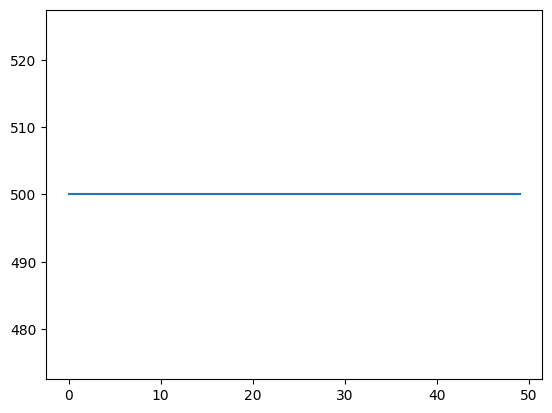


Recompensa de Media: 500.0 



In [40]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3


### Construcción de base de datos experta con 1 trayectoria 

In [41]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [42]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1500


In [43]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [44]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 5.7282310e-03 -3.8312376e-02  3.1016285e-02  9.0088570e-03]
 [ 4.9619833e-03  1.5635134e-01  3.1196462e-02 -2.7372897e-01]
 [ 8.0890100e-03 -3.9201517e-02  2.5721883e-02  2.8627882e-02]
 ...
 [-2.9287953e-02  2.1513289e-01  6.6173290e-03 -3.3733398e-01]
 [-2.4985295e-02  1.9917408e-02 -1.2935029e-04 -4.2571660e-02]
 [-2.4586946e-02 -1.7520268e-01 -9.8078350e-04  2.5007045e-01]]
	Acciones reales: 
 [1 0 1 ... 0 0 1]


### Separación de Train y Test

In [45]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 5.7282310e-03 -3.8312376e-02  3.1016285e-02  9.0088570e-03
   0.0000000e+00  1.0000000e+00]
 [ 4.9619833e-03  1.5635134e-01  3.1196462e-02 -2.7372897e-01
   1.0000000e+00  0.0000000e+00]
 [ 8.0890100e-03 -3.9201517e-02  2.5721883e-02  2.8627882e-02
   0.0000000e+00  1.0000000e+00]
 ...
 [-2.9287953e-02  2.1513289e-01  6.6173290e-03 -3.3733398e-01
   1.0000000e+00  0.0000000e+00]
 [-2.4985295e-02  1.9917408e-02 -1.2935029e-04 -4.2571660e-02
   1.0000000e+00  0.0000000e+00]
 [-2.4586946e-02 -1.7520268e-01 -9.8078350e-04  2.5007045e-01
   0.0000000e+00  1.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1200
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 300


In [46]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [47]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [48]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [49]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan3.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.6289845

g_loss= -1.2089212
 1/14 [=>............................] - ETA: 1:40:47 - d_loss: 2.6290 - g_loss: -1.2089


d_loss= 2.5845017

g_loss= -0.94972074
 2/14 [===>..........................] - ETA: 1:32:08 - d_loss: 2.6067 - g_loss: -1.0793


d_loss= 2.674271

g_loss= -0.8244537
 3/14 [=====>........................] - ETA: 1:25:38 - d_loss: 2.6293 - g_loss: -0.9944


d_loss= 2.6239052

g_loss= -1.2234056
 4/14 [=======>......................] - ETA: 1:17:31 - d_loss: 2.6279 - g_loss: -1.0516


d_loss= 2.5944042

g_loss= -1.1377223
 5/14 [=========>....................] - ETA: 1:09:30 - d_loss: 2.6212 - g_loss: -1.0688


d_loss= 2.5870194

g_loss= -1.1998097
 6/14 [===========>..................] - ETA: 1:01:19 - d_loss: 2.6155 - g_loss: -1.0907


d_loss= 2.6034532

g_loss= -1.2339392
 7/14 [==============>...............] - ETA: 53:31 - d_loss: 2.6138 - g_loss: -1.1111  


d_loss= 2.5973024

g_loss= -0.869532
 8/14 [================>.............] - ETA: 45:45 - d_l

### Evaluación de GAIL

In [50]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.6419 - accuracy: 0.0000e+00
>Loss real: 
0.6535306572914124
>Loss fake: 
0.6419296860694885


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

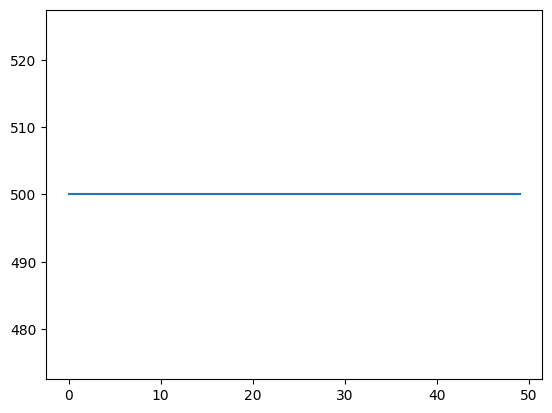


Recompensa de Media: 500.0 



In [51]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4


### Construcción de base de datos experta con 4 trayectoria 

In [52]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [53]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2000


In [54]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [55]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03044969  0.14637755 -0.00377016 -0.21959685]
 [-0.02752214 -0.04869031 -0.0081621   0.07189444]
 [-0.02849595  0.1465477  -0.00672421 -0.22335246]]
	Acciones reales: 
 [1 0 1 ... 0 1 0]


### Separación de Train y Test

In [56]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.00572823 -0.03831238  0.03101629  0.00900886  0.          1.        ]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897  1.          0.        ]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788  0.          1.        ]
 ...
 [-0.03044969  0.14637755 -0.00377016 -0.21959685  1.          0.        ]
 [-0.02752214 -0.04869031 -0.0081621   0.07189444  0.          1.        ]
 [-0.02849595  0.1465477  -0.00672421 -0.22335246  1.          0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1600
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 400


In [57]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [58]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [59]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [60]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan4.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.542076

g_loss= -0.79300094
 1/18 [>.............................] - ETA: 2:12:46 - d_loss: 2.5421 - g_loss: -0.7930


d_loss= 2.5521266

g_loss= -1.1777778
 2/18 [==>...........................] - ETA: 2:00:51 - d_loss: 2.5471 - g_loss: -0.9854


d_loss= 2.5302887

g_loss= -0.90146625
 3/18 [====>.........................] - ETA: 1:55:36 - d_loss: 2.5415 - g_loss: -0.9574


d_loss= 2.5423343

g_loss= -0.6153197
 4/18 [=====>........................] - ETA: 1:47:27 - d_loss: 2.5417 - g_loss: -0.8719


d_loss= 2.567187

g_loss= -1.1002028
 5/18 [=======>......................] - ETA: 1:42:12 - d_loss: 2.5468 - g_loss: -0.9176


d_loss= 2.5559196

g_loss= -1.1382117
 6/18 [=========>....................] - ETA: 1:34:23 - d_loss: 2.5483 - g_loss: -0.9543


d_loss= 2.528142

g_loss= -0.7512719
 7/18 [==========>...................] - ETA: 1:26:22 - d_loss: 2.5454 - g_loss: -0.9253


d_loss= 2.5088196

g_loss= -0.8989172
 8/18 [============>.................] - ETA: 1:19:00 - d

### Evaluación de GAIL

In [61]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.5830 - accuracy: 0.0000e+00
>Loss real: 
0.5781092643737793
>Loss fake: 
0.5829794406890869


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

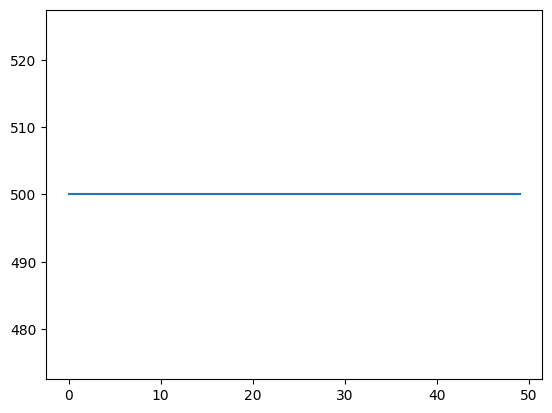


Recompensa de Media: 500.0 



In [62]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5


### Construcción de base de datos experta con 5 trayectoria 

In [63]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [64]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

2500


In [65]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [66]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.02261659 -0.16291702  0.00098082  0.25042167]
 [-0.02587493  0.03219091  0.00598926 -0.04195173]
 [-0.02523111  0.22722647  0.00515022 -0.332739  ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]


### Separación de Train y Test

In [67]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 5.7282310e-03 -3.8312376e-02  3.1016285e-02  9.0088570e-03
   0.0000000e+00  1.0000000e+00]
 [ 4.9619833e-03  1.5635134e-01  3.1196462e-02 -2.7372897e-01
   1.0000000e+00  0.0000000e+00]
 [ 8.0890100e-03 -3.9201517e-02  2.5721883e-02  2.8627882e-02
   0.0000000e+00  1.0000000e+00]
 ...
 [-2.2616590e-02 -1.6291702e-01  9.8082270e-04  2.5042167e-01
   0.0000000e+00  1.0000000e+00]
 [-2.5874930e-02  3.2190910e-02  5.9892560e-03 -4.1951735e-02
   0.0000000e+00  1.0000000e+00]
 [-2.5231112e-02  2.2722647e-01  5.1502213e-03 -3.3273900e-01
   1.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2000
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 500


In [68]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [69]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [70]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [71]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI GymCuando nos sa
gym.logger.set_level(40)

history=gan5.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.4715126

g_loss= -0.891493
 1/23 [>.............................] - ETA: 2:47:31 - d_loss: 2.4715 - g_loss: -0.8915


d_loss= 2.4639573

g_loss= -0.725038
 2/23 [=>............................] - ETA: 2:37:22 - d_loss: 2.4677 - g_loss: -0.8083


d_loss= 2.4285548

g_loss= nan
 3/23 [==>...........................] - ETA: 2:32:24 - d_loss: 2.4547 - g_loss: nan    


d_loss= 2.532225

g_loss= -0.830414
 4/23 [====>.........................] - ETA: 2:25:27 - d_loss: 2.4741 - g_loss: nan


d_loss= 2.4126983

g_loss= -1.1243919
 5/23 [=====>........................] - ETA: 2:20:16 - d_loss: 2.4618 - g_loss: nan


d_loss= 2.456843

g_loss= -0.95814013
 6/23 [======>.......................] - ETA: 2:15:05 - d_loss: 2.4610 - g_loss: nan


d_loss= 2.4314651

g_loss= -1.1352364
 7/23 [========>.....................] - ETA: 2:08:06 - d_loss: 2.4568 - g_loss: nan


d_loss= 2.4387815

g_loss= -1.055678
 8/23 [=========>....................] - ETA: 2:00:16 - d_loss: 2.4545 - g_loss: nan

### Evaluación de GAIL

In [72]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.4777 - accuracy: 0.0000e+00
>Loss real: 
0.4801226854324341
>Loss fake: 
0.47767895460128784


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

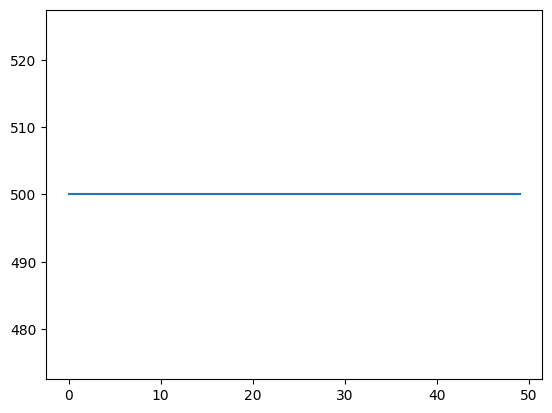


Recompensa de Media: 500.0 



In [73]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6


### Construcción de base de datos experta con 6 trayectoria 

In [74]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [75]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

3000


In [76]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [77]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.02217253  0.17468227  0.00079885 -0.2510374 ]
 [-0.01867888 -0.02045107 -0.0042219   0.0418974 ]
 [-0.0190879   0.17473117 -0.00338395 -0.25211456]]
	Acciones reales: 
 [1 0 1 ... 0 1 0]


### Separación de Train y Test

In [78]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 5.7282310e-03 -3.8312376e-02  3.1016285e-02  9.0088570e-03
   0.0000000e+00  1.0000000e+00]
 [ 4.9619833e-03  1.5635134e-01  3.1196462e-02 -2.7372897e-01
   1.0000000e+00  0.0000000e+00]
 [ 8.0890100e-03 -3.9201517e-02  2.5721883e-02  2.8627882e-02
   0.0000000e+00  1.0000000e+00]
 ...
 [-2.2172527e-02  1.7468227e-01  7.9885125e-04 -2.5103740e-01
   1.0000000e+00  0.0000000e+00]
 [-1.8678881e-02 -2.0451074e-02 -4.2218966e-03  4.1897405e-02
   0.0000000e+00  1.0000000e+00]
 [-1.9087903e-02  1.7473117e-01 -3.3839485e-03 -2.5211456e-01
   1.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2400
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 600


In [79]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [80]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [81]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [82]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan6.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.3685048

g_loss= -1.2273296
 1/27 [>.............................] - ETA: 3:15:06 - d_loss: 2.3685 - g_loss: -1.2273


d_loss= 2.3596258

g_loss= -1.1086441
 2/27 [=>............................] - ETA: 3:09:04 - d_loss: 2.3641 - g_loss: -1.1680


d_loss= 2.365448

g_loss= -1.011794
 3/27 [==>...........................] - ETA: 3:01:24 - d_loss: 2.3645 - g_loss: -1.1159


d_loss= 2.3252032

g_loss= -0.99648356
 4/27 [===>..........................] - ETA: 2:53:02 - d_loss: 2.3547 - g_loss: -1.0861


d_loss= 2.3885553

g_loss= -0.98502266
 5/27 [====>.........................] - ETA: 2:45:22 - d_loss: 2.3615 - g_loss: -1.0659


d_loss= 2.3900044

g_loss= -1.1982098
 6/27 [=====>........................] - ETA: 2:38:20 - d_loss: 2.3662 - g_loss: -1.0879


d_loss= 2.3384948

g_loss= -1.2535645
 7/27 [======>.......................] - ETA: 2:30:39 - d_loss: 2.3623 - g_loss: -1.1116


d_loss= 2.330599

g_loss= -0.7471645
 8/27 [=======>......................] - ETA: 2:22:38 - d

### Evaluación de GAIL

In [83]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)

1/1 [==============================] - 0s 25ms/step - loss: 0.3601 - accuracy: 0.0000e+00
>Loss real: 
0.3607860803604126
>Loss fake: 
0.36013343930244446


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

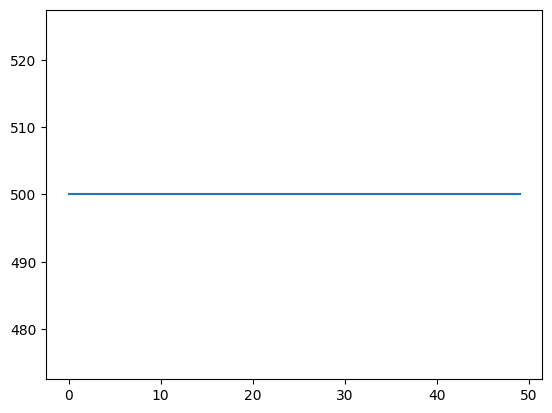


Recompensa de Media: 500.0 



In [84]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7


### Construcción de base de datos experta con 7 trayectoria 

In [85]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [86]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

3500


In [87]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [88]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 5.7282310e-03 -3.8312376e-02  3.1016285e-02  9.0088570e-03]
 [ 4.9619833e-03  1.5635134e-01  3.1196462e-02 -2.7372897e-01]
 [ 8.0890100e-03 -3.9201517e-02  2.5721883e-02  2.8627882e-02]
 ...
 [-3.4051698e-02 -1.4851935e-01 -4.6977460e-03  2.5984666e-01]
 [-3.7022088e-02  4.6669340e-02  4.9918704e-04 -3.4314286e-02]
 [-3.6088698e-02 -1.4845976e-01 -1.8709873e-04  2.5852610e-01]]
	Acciones reales: 
 [1 0 1 ... 1 0 1]


### Separación de Train y Test

In [89]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 5.7282310e-03 -3.8312376e-02  3.1016285e-02  9.0088570e-03
   0.0000000e+00  1.0000000e+00]
 [ 4.9619833e-03  1.5635134e-01  3.1196462e-02 -2.7372897e-01
   1.0000000e+00  0.0000000e+00]
 [ 8.0890100e-03 -3.9201517e-02  2.5721883e-02  2.8627882e-02
   0.0000000e+00  1.0000000e+00]
 ...
 [-3.4051698e-02 -1.4851935e-01 -4.6977460e-03  2.5984666e-01
   0.0000000e+00  1.0000000e+00]
 [-3.7022088e-02  4.6669340e-02  4.9918704e-04 -3.4314286e-02
   1.0000000e+00  0.0000000e+00]
 [-3.6088698e-02 -1.4845976e-01 -1.8709873e-04  2.5852610e-01
   0.0000000e+00  1.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2800
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 700


In [90]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [91]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [92]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [93]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan7.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.2261398

g_loss= -1.1993479
 1/32 [..............................] - ETA: 3:43:10 - d_loss: 2.2261 - g_loss: -1.1993


d_loss= 2.2570183

g_loss= -0.9213828
 2/32 [>.............................] - ETA: 3:36:48 - d_loss: 2.2416 - g_loss: -1.0604


d_loss= 2.2680671

g_loss= -1.2020552
 3/32 [=>............................] - ETA: 3:30:32 - d_loss: 2.2504 - g_loss: -1.1076


d_loss= 2.2346883

g_loss= -1.1714077
 4/32 [==>...........................] - ETA: 3:24:06 - d_loss: 2.2465 - g_loss: -1.1235


d_loss= 2.2227268

g_loss= -0.85562015
 5/32 [===>..........................] - ETA: 3:18:06 - d_loss: 2.2417 - g_loss: -1.0700


d_loss= 2.2489023

g_loss= -1.0120468
 6/32 [====>.........................] - ETA: 3:11:29 - d_loss: 2.2429 - g_loss: -1.0603


d_loss= 2.2634614

g_loss= -1.0018247
 7/32 [=====>........................] - ETA: 3:03:46 - d_loss: 2.2459 - g_loss: -1.0520


d_loss= 2.1967328

g_loss= -1.0160702
 8/32 [======>.......................] - ETA: 2:55:57 -

### Evaluación de GAIL

In [94]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)

1/1 [==============================] - 0s 14ms/step - loss: 0.2108 - accuracy: 0.0000e+00
>Loss real: 
0.20734503865242004
>Loss fake: 
0.2107636034488678


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

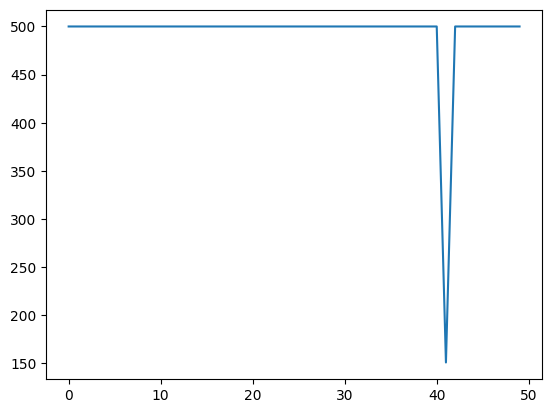


Recompensa de Media: 493.02 



In [95]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8


### Construcción de base de datos experta con 8 trayectoria 

In [96]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [97]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

4000


In [98]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [99]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.0186169   0.1786086  -0.00126522 -0.25009453]
 [-0.01504473 -0.01649527 -0.00626712  0.04218904]
 [-0.01537464 -0.2115268  -0.00542333  0.33288807]]
	Acciones reales: 
 [1 0 1 ... 0 0 1]


### Separación de Train y Test

In [100]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.00572823 -0.03831238  0.03101629  0.00900886  0.          1.        ]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897  1.          0.        ]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788  0.          1.        ]
 ...
 [-0.0186169   0.1786086  -0.00126522 -0.25009453  1.          0.        ]
 [-0.01504473 -0.01649527 -0.00626712  0.04218904  1.          0.        ]
 [-0.01537464 -0.2115268  -0.00542333  0.33288807  0.          1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3200
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 800


In [101]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [102]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [103]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [104]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan8.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 2.1068065

g_loss= -0.9082667
 1/36 [..............................] - ETA: 4:33:32 - d_loss: 2.1068 - g_loss: -0.9083


d_loss= 2.0903964

g_loss= -0.9949434
 2/36 [>.............................] - ETA: 4:47:25 - d_loss: 2.0986 - g_loss: -0.9516


d_loss= 2.1101513

g_loss= -0.9427878
 3/36 [=>............................] - ETA: 4:28:49 - d_loss: 2.1025 - g_loss: -0.9487


d_loss= 2.1009626

g_loss= -1.2811124
 4/36 [==>...........................] - ETA: 4:16:22 - d_loss: 2.1021 - g_loss: -1.0318


d_loss= 2.0617013

g_loss= -1.1984996
 5/36 [===>..........................] - ETA: 4:06:54 - d_loss: 2.0940 - g_loss: -1.0651


d_loss= 2.100798

g_loss= -1.0087556
 6/36 [====>.........................] - ETA: 4:01:31 - d_loss: 2.0951 - g_loss: -1.0557


d_loss= 2.0466273

g_loss= -0.9472334
 7/36 [====>.........................] - ETA: 3:55:14 - d_loss: 2.0882 - g_loss: -1.0402


d_loss= 2.0832665

g_loss= -0.89147377
 8/36 [=====>........................] - ETA: 3:49:49 - 

### Evaluación de GAIL

In [105]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)

1/1 [==============================] - 0s 16ms/step - loss: 0.0744 - accuracy: 0.0000e+00
>Loss real: 
0.08181589096784592
>Loss fake: 
0.07439804077148438


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

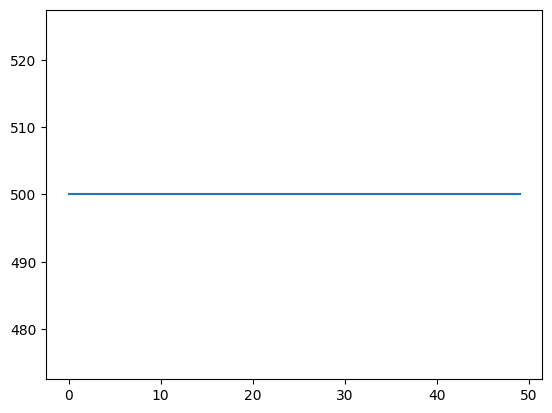


Recompensa de Media: 500.0 



In [106]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9


### Construcción de base de datos experta con 9 trayectoria 

In [107]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [108]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

4500


In [109]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [110]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03005801 -0.22147515  0.00891429  0.30272087]
 [-0.03448751 -0.02648138  0.01496871  0.0128626 ]
 [-0.03501714  0.16842274  0.01522596 -0.27506018]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]


### Separación de Train y Test

In [111]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.00572823 -0.03831238  0.03101629  0.00900886  0.          1.        ]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897  1.          0.        ]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788  0.          1.        ]
 ...
 [-0.03005801 -0.22147515  0.00891429  0.30272087  0.          1.        ]
 [-0.03448751 -0.02648138  0.01496871  0.0128626   0.          1.        ]
 [-0.03501714  0.16842274  0.01522596 -0.27506018  1.          0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3600
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 900


In [112]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [113]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [114]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [115]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan9.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 1.9952602

g_loss= -0.83535737
 1/40 [..............................] - ETA: 5:20:22 - d_loss: 1.9953 - g_loss: -0.8354


d_loss= 1.9649125

g_loss= -1.2702848
 2/40 [>.............................] - ETA: 5:22:14 - d_loss: 1.9801 - g_loss: -1.0528


d_loss= 1.9753921

g_loss= -0.6540884
 3/40 [=>............................] - ETA: 5:11:09 - d_loss: 1.9785 - g_loss: -0.9199


d_loss= 2.007296

g_loss= -0.7901392
 4/40 [==>...........................] - ETA: 5:01:56 - d_loss: 1.9857 - g_loss: -0.8875


d_loss= 1.9838417

g_loss= -0.8374457
 5/40 [==>...........................] - ETA: 4:54:59 - d_loss: 1.9853 - g_loss: -0.8775


d_loss= 1.9735923

g_loss= -1.2216411
 6/40 [===>..........................] - ETA: 4:46:41 - d_loss: 1.9834 - g_loss: -0.9348


d_loss= 1.9769558

g_loss= -1.2608734
 7/40 [====>.........................] - ETA: 4:38:34 - d_loss: 1.9825 - g_loss: -0.9814


d_loss= 2.0012953

g_loss= -1.075411
 8/40 [=====>........................] - ETA: 4:29:42 - d

### Evaluación de GAIL

In [116]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0168 - accuracy: 0.0000e+00
>Loss real: 
0.018305018544197083
>Loss fake: 
0.016794763505458832


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

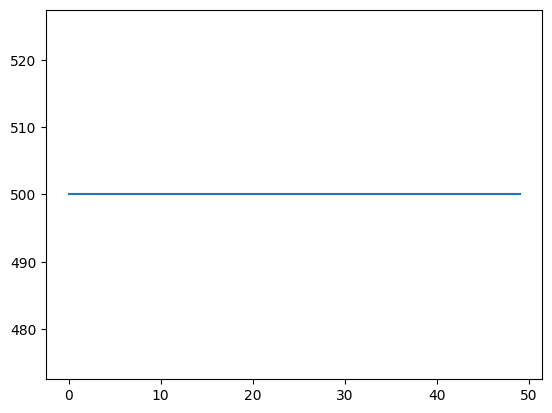


Recompensa de Media: 500.0 



In [117]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10


### Construcción de base de datos experta con 10 trayectoria 

In [118]:
expert_observations = np.genfromtxt("observations_CartPole_.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_CartPole_.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_CartPole_.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

In [119]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

5000


In [120]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [121]:
print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[ 0.00572823 -0.03831238  0.03101629  0.00900886]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116]
 [-0.03340117  0.04289266  0.01530002 -0.04074667]
 [-0.03254332  0.23779191  0.01448509 -0.3285633 ]]
	Acciones reales: 
 [1 0 1 ... 1 1 0]


### Separación de Train y Test

In [122]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[ 0.00572823 -0.03831238  0.03101629  0.00900886  0.          1.        ]
 [ 0.00496198  0.15635134  0.03119646 -0.27372897  1.          0.        ]
 [ 0.00808901 -0.03920152  0.02572188  0.02862788  0.          1.        ]
 ...
 [-0.03035956 -0.1520803   0.0103268   0.24866116  0.          1.        ]
 [-0.03340117  0.04289266  0.01530002 -0.04074667  0.          1.        ]
 [-0.03254332  0.23779191  0.01448509 -0.3285633   1.          0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4000
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1000


In [123]:
env= gym.make('CartPole-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [124]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [125]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [126]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan10.fit(X_train,
    epochs=EPOCHS,batch_size=BATCH_SIZE)




d_loss= 1.9244822

g_loss= -0.9320656
 1/45 [..............................] - ETA: 5:35:47 - d_loss: 1.9245 - g_loss: -0.9321


d_loss= 1.8807418

g_loss= -1.2312539
 2/45 [>.............................] - ETA: 5:14:57 - d_loss: 1.9026 - g_loss: -1.0817


d_loss= 1.934237

g_loss= -1.1551963
 3/45 [=>............................] - ETA: 5:08:28 - d_loss: 1.9132 - g_loss: -1.1062


d_loss= 1.9074911

g_loss= -0.8033719
 4/45 [=>............................] - ETA: 4:59:37 - d_loss: 1.9117 - g_loss: -1.0305


d_loss= 1.8802083

g_loss= -0.862467
 5/45 [==>...........................] - ETA: 4:54:08 - d_loss: 1.9054 - g_loss: -0.9969


d_loss= 1.8877099

g_loss= -0.80291784
 6/45 [===>..........................] - ETA: 4:47:19 - d_loss: 1.9025 - g_loss: -0.9645


d_loss= 1.8980758

g_loss= -0.86416537
 7/45 [===>..........................] - ETA: 4:40:18 - d_loss: 1.9018 - g_loss: -0.9502


d_loss= 1.9142215

g_loss= -0.9252326
 8/45 [====>.........................] - ETA: 4:33:00 - 

### Evaluación de GAIL

In [127]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)

1/1 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 0.0000e+00
>Loss real: 
0.002202261472120881
>Loss fake: 
0.0023386504035443068


Episode  0 Total reward: 500.0
Episode  1 Total reward: 500.0
Episode  2 Total reward: 500.0
Episode  3 Total reward: 500.0
Episode  4 Total reward: 500.0
Episode  5 Total reward: 500.0
Episode  6 Total reward: 500.0
Episode  7 Total reward: 500.0
Episode  8 Total reward: 500.0
Episode  9 Total reward: 500.0
Episode  10 Total reward: 500.0
Episode  11 Total reward: 500.0
Episode  12 Total reward: 500.0
Episode  13 Total reward: 500.0
Episode  14 Total reward: 500.0
Episode  15 Total reward: 500.0
Episode  16 Total reward: 500.0
Episode  17 Total reward: 500.0
Episode  18 Total reward: 500.0
Episode  19 Total reward: 500.0
Episode  20 Total reward: 500.0
Episode  21 Total reward: 500.0
Episode  22 Total reward: 500.0
Episode  23 Total reward: 500.0
Episode  24 Total reward: 500.0
Episode  25 Total reward: 500.0
Episode  26 Total reward: 500.0
Episode  27 Total reward: 500.0
Episode  28 Total reward: 500.0
Episode  29 Total reward: 500.0
Episode  30 Total reward: 500.0
Episode  31 Total 

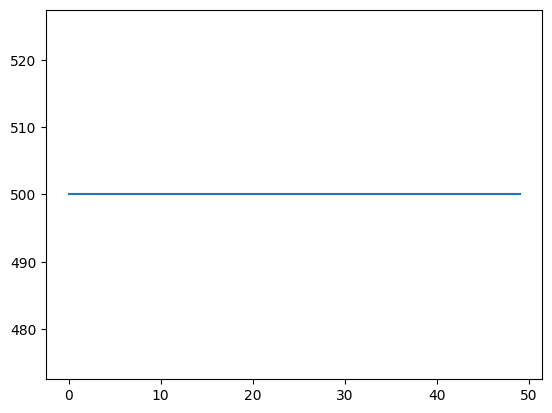


Recompensa de Media: 500.0 



In [128]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')